In [4]:
from itertools import product
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**Files description**

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


### Loading data

In [5]:
data_path = os.path.join('datasets', 'future_sales')

sales_train_path = os.path.join(data_path, 'sales_train.csv')
train_df = pd.read_csv(sales_train_path)

test_path = os.path.join(data_path, 'test.csv')
test_df = pd.read_csv(test_path)

items_path = os.path.join(data_path, 'items.csv')
temp_df = pd.read_csv(items_path)
train_df = pd.merge(train_df, temp_df, on='item_id', how='left')

items_category_path = os.path.join(data_path, 'item_categories.csv')
temp_df = pd.read_csv(items_category_path)
train_df = pd.merge(train_df, temp_df, on='item_category_id', how='left')

shops_path = os.path.join(data_path, 'shops.csv')
temp_df = pd.read_csv(shops_path)
train_df = pd.merge(train_df, temp_df, on='shop_id', how='left')

print('Shape: ', train_df.shape)

Shape:  (2935849, 10)


### Data Fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

Using only shop ids and item ids which are present in test dataset.

In [6]:
test_shop_id = test_df['shop_id'].unique()
test_item_id = test_df['item_id'].unique()

train_df = train_df.loc[train_df['shop_id'].isin(test_shop_id)]
train_df = train_df.loc[train_df['item_id'].isin(test_item_id)]
train_df.shape

(1224439, 10)

No string features

In [7]:
train_df.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
10,03.01.2013,0,25,2574,399.0,2.0,55
11,05.01.2013,0,25,2574,399.0,1.0,55
12,07.01.2013,0,25,2574,399.0,1.0,55
13,08.01.2013,0,25,2574,399.0,2.0,55


## Visualisations

In [ ]:
train_df['sales'] = train_df['item_price'] * train_df['item_cnt_day']

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))
total_shop = train_df.groupby('shop_id', as_index=False)['sales'].sum()
sns.barplot(x='shop_id', y='sales', data=total_shop, ax=ax[0])

total_shop = train_df.groupby('item_category_id', as_index=False)['sales'].sum()
sns.barplot(x='item_category_id', y='sales', data=total_shop, ax=ax[1])

In [ ]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(2, 5, hspace=0.4)

ax1 = fig.add_subplot(grid[:, 0:3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, 3:])
date_block_group = train_df.groupby('date_block_num')
sns.barplot(x='date_block_num', y='sales', data=train_df, ax=ax1)

## Grouping by month

In [8]:
cols_to_group = ['date_block_num', 'shop_id', 'item_category_id', 'item_id']
train_group = train_df.groupby(cols_to_group).agg({'item_price': [np.mean, np.sum],
                                                   'item_cnt_day': [np.mean, np.sum]})
train_group.reset_index(inplace=True)
train_group.columns = cols_to_group + ['price_mean', 'price', 'cnt_mean', 'cnt']

In [20]:
shop_ids = train_group['shop_id'].unique()
item_ids = train_group['item_id'].unique()
date_blocks = train_group['date_block_num'].unique()
empty_df = list(product(date_blocks, shop_ids, item_ids))
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
all_train = pd.merge(empty_df, train_group, on=['date_block_num','shop_id','item_id'], how='left')
all_train.fillna(0, inplace=True)

In [21]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,33.000000
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,59.000000
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,22167.000000
item_category_id,6734448.0,3.786271,13.212956,0.0,0.00,0.0,0.00,83.000000
price_mean,6734448.0,81.230111,534.732650,0.0,0.00,0.0,0.00,42990.000000
price,6734448.0,187.392884,2177.443736,0.0,0.00,0.0,0.00,515573.589744
cnt_mean,6734448.0,0.097299,0.612203,-2.0,0.00,0.0,0.00,1000.000000
cnt,6734448.0,0.240223,3.456640,-4.0,0.00,0.0,0.00,2253.000000


### EDA

Removing outliers

percentage of obs with cnt more than 20:  6078
percentage of obs with cnt less than 0:  252
percentage of obs with price more than 400 000:  11


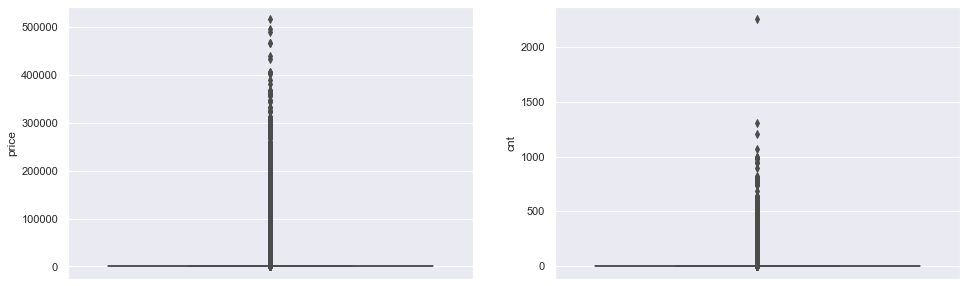

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(y=all_train['price'], ax=ax1)
sns.boxplot(y=all_train['cnt'], ax=ax2)

print('percentage of obs with cnt more than 20: ', all_train[all_train['cnt'] > 20].shape[0])
print('percentage of obs with cnt less than 0: ', all_train[all_train['cnt'] < 0].shape[0])
print('percentage of obs with price more than 400 000: ', all_train[all_train['price'] > 400_000].shape[0])

In [19]:
all_train = all_train.loc[(all_train['cnt'] <= 20) 
                          & (all_train['cnt'] >= 0) 
                          & (all_train['price'] < 400_000)].copy()

In [18]:
def get_year(x):
    return x // 12 + 2013

def get_month(x):
    return x % 12

all_train['year'] = all_train['date_block_num'].apply(get_year)
all_train['month'] = all_train['date_block_num'].apply(get_month)
all_train['sales'] = all_train['cnt'] * all_train['price']

C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
temp = all_train.groupby(['year', 'month'])[['price', 'cnt', 'sales']].sum()
temp.reset_index(inplace=True)
sns.barplot(x='month', y='sales', hue='year', data=temp)

## Feature engineering

In [ ]:
cols_to_group = ['shop_id', 'item_category_id', 'item_id']
all_train['lag_price'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['price'].shift(-1)
all_train['lag_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-1)
all_train['lag_2_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-2)
all_train['lag_3_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-3)
cols = ['lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'lag_price']
all_train[cols] = all_train[cols].fillna(0)

In [ ]:
rolling_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
rolling_min = lambda x: x.rolling(window=3, min_periods=1).min()
rolling_max = lambda x: x.rolling(window=3, min_periods=1).max()

all_train['rolling_mean_cnt'] = all_train.sort_values('date_block_num') \
                                         .groupby(cols_to_group)['cnt'].apply(rolling_mean)
all_train['rolling_min_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_min)
all_train['rolling_max_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_max)

In [ ]:
all_train['change_cnt'] = all_train['cnt'] - all_train['lag_cnt']
all_train['change_2_cnt'] = all_train['cnt'] - all_train['lag_2_cnt']
all_train['change_3_cnt'] = all_train['cnt'] - all_train['lag_3_cnt']

In [ ]:
all_train['target'] = all_train.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['cnt'].shift(1)

In [ ]:
all_train.describe().T

## One item

In [ ]:
one_item = all_train.loc[(all_train['shop_id'] == 25) & (all_train['item_id'] == 8093)]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[0], label='original')
sns.lineplot(x='date_block_num', y='lag_cnt', data=one_item, ax=ax[0], label='1 period lag')
sns.lineplot(x='date_block_num', y='lag_2_cnt', data=one_item, ax=ax[0], label='2 periods lag')
sns.lineplot(x='date_block_num', y='lag_3_cnt', data=one_item, ax=ax[0], label='3 periods lag')
ax[0].legend()
ax[0].set_title('Checking lags')

sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[1], label='original')
sns.lineplot(x='date_block_num', y='rolling_mean_cnt', data=one_item, ax=ax[1], label='rolling mean')
sns.lineplot(x='date_block_num', y='rolling_min_cnt', data=one_item, ax=ax[1], label='rolling min')
sns.lineplot(x='date_block_num', y='rolling_max_cnt', data=one_item, ax=ax[1], label='rolling max')
ax[1].legend()
ax[1].set_title('Checking rollings');

In [ ]:
one_item.head()

In [ ]:
all_train.describe().T.round(2)

### Preprocessing

In [ ]:
df = all_train.loc[all_train['date_block_num'] > 2].copy()

In [ ]:
columns = ['lag_price', 'lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'rolling_mean_cnt',
           'rolling_min_cnt', 'rolling_max_cnt']
for col in columns:
    print(col)
    temp = df.groupby(['shop_id'])[col].median()
    df = pd.merge(df, temp, left_on='shop_id', right_index=True, suffixes=('', '_y'), how='left')
    df.loc[df[col].isna(), col] = df[f'{col}_y']
    df.drop(columns=f'{col}_y', inplace=True)

col_means = df[columns].mean()
df[columns].fillna(col_means, inplace=True)

## Machine learning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
train_df = df.loc[df['date_block_num'] < 28].copy()
valid_df = df.loc[df['date_block_num'] >= 28].copy()

for set_ in [train_df, valid_df]:
    set_.drop(columns=['date_block_num', 'sales'], inplace=True)
print(f'Valid split: {valid_df.shape[0] / (train_df.shape[0] + valid_df.shape[0])}')

Adding features after spliting

In [ ]:
shop_mean = train_df.groupby('shop_id')['cnt'].mean()
shop_mean = shop_mean.reset_index()
shop_mean.rename(columns={'cnt': 'shop_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_mean, on='shop_id', how='left')
valid_df = pd.merge(valid_df, shop_mean, on='shop_id', how='left')

item_mean = train_df.groupby('item_id')['cnt'].mean()
item_mean = item_mean.reset_index()
item_mean.rename(columns={'cnt': 'item_mean'}, inplace=True)
train_df = pd.merge(train_df, item_mean, on='item_id', how='left')
valid_df = pd.merge(valid_df, item_mean, on='item_id', how='left')

shop_item_mean = train_df.groupby(['shop_id', 'item_id'])['cnt'].mean()
shop_item_mean = shop_item_mean.reset_index()
shop_item_mean.rename(columns={'cnt': 'shop_item_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')
valid_df = pd.merge(valid_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')

category_mean = train_df.groupby('item_category_id')['cnt'].mean()
category_mean = category_mean.reset_index()
category_mean.rename(columns={'cnt': 'category_mean'}, inplace=True)
train_df = pd.merge(train_df, category_mean, on='item_category_id', how='left')
valid_df = pd.merge(valid_df, category_mean, on='item_category_id', how='left')

In [ ]:
X_train = train_df.drop(columns='target')
Y_train = train_df['target']

X_valid = valid_df.drop(columns='target')
Y_valid = valid_df['target']

In [ ]:
rf_features = ['shop_id', 'item_id', 'cnt', 'year', 'lag_cnt', 
               'shop_mean', 'item_mean', 'change_cnt', 'rolling_mean_cnt']

model = RandomForestRegressor(verbose=2)
model.fit(X_train[rf_features], Y_train)

In [ ]:
Y_pred = model.predict(X_valid[rf_features])
np.sqrt(mean_squared_error(Y_valid, Y_pred))

In [ ]:
x = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), columns=['feature', 'imp'])

In [ ]:
x.sort_values('imp', ascending=False)

In [ ]:
plt.scatter(Y_valid, Y_pred)